In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch as t
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joint_tsne
import pickle
t.manual_seed(1)

In [3]:
'''Load data'''
# all epochs
df_latent_all_epochs = pickle.load(open("df_latent_all_epochs_2000_BI.pkl", "rb"))
epochs = df_latent_all_epochs.shape[0]//192
# print(df_latent_all_epochs.shape, epochs)
# print(df_latent_all_epochs.head())
# create column names
latent_length = 40
latent_B_cols = ['latentB_'+str(i) for i in range(latent_length)]
latent_I_cols = ['latentI_'+str(i) for i in range(latent_length)]

# select the last epoch
epoch = 1999
df_latent = df_latent_all_epochs.loc[df_latent_all_epochs['epoch'] == epoch]
# convert panda dataframe to numpy array
data_subset_B = df_latent[latent_B_cols].values
data_subset_I = df_latent[latent_I_cols].values
y_array = df_latent['y'].values

# convert numpy array to torch tensor
# device = torch.device("cuda:{}".format(args.cuda))
XB = torch.from_numpy(data_subset_B).float() #.to(device)
XI = torch.from_numpy(data_subset_I).float() #.to(device)
C = torch.from_numpy(y_array).float() #.to(device)

print(XB.dtype, XI.dtype, C.dtype)
print(type(XB), type(XI), type(C))
print(XB.shape, XI.shape, C.shape)
# TODO: preprocess by batch normalization

torch.float32 torch.float32 torch.float32
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([192, 40]) torch.Size([192, 40]) torch.Size([192])


In [4]:
# # sklearn TSNE
# resB=TSNE(n_components=2,init='pca').fit_transform(XB.numpy())
# plt.scatter(resB[:,0],resB[:,1],c=C.numpy(), marker='o')
# resI=TSNE(n_components=2,init='pca').fit_transform(XI.numpy())
# plt.scatter(resI[:,0],resI[:,1],c=C.numpy(), marker='x')

In [5]:
# # customize TSNE
# T=tsne.myTSNE(XB)
# res=T.train(epoch=600, lr=50, weight_decay=0., momentum=0.5, show=True).numpy()
# plt.scatter(res[:,0],res[:,1],c=C.numpy())

In [6]:
mat_list = ["CP", "CT", "BT", "LF", "PP", "FL", "S2", "P2", "PS", "PT", "S1", "CK", "EV", "P1", "FB", "WH", "SF", "SS", "FM", "MT"]
print(len(mat_list))

20


Computing pairwise distances...
Computing P-values for point 0 of 192...
Mean value of sigma: 2.449369
training started @lr=50,epoch=400,weight_decay=0,momentum=1
running epoch=0
running epoch=100
running epoch=200
running epoch=300
train complete!
final loss=19.64592742919922


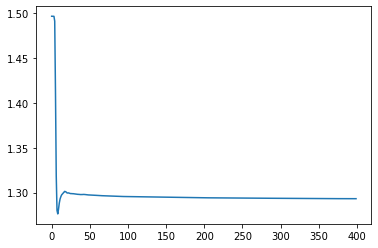

Computing pairwise distances...
Computing P-values for point 0 of 192...
Mean value of sigma: 2.425251
training started @lr=50,epoch=400,weight_decay=0,momentum=1
running epoch=0
running epoch=100
running epoch=200
running epoch=300
train complete!
final loss=19.79677963256836


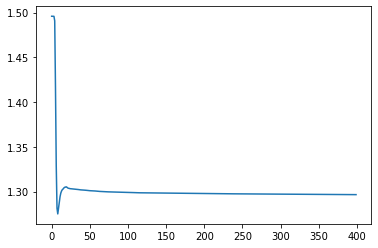

In [7]:
# initialize and train pytorch TSNE
TB=joint_tsne.myTSNE(XB)
resB=TB.train(epoch=400, lr=50, weight_decay=0, momentum=1, show=True, savefig=True, figname="TB_loss.png").numpy()
TI=joint_tsne.myTSNE(XI)
resI=TI.train(epoch=400, lr=50, weight_decay=0, momentum=1, show=True, savefig=True, figname="TI_loss.png").numpy()

In [8]:
# prepare dataframe for sns
import seaborn as sns
import pandas as pd

tsne_columns = ['latentB_tsne-2d-one', 'latentB_tsne-2d-two', 'latentI_tsne-2d-one', 'latentI_tsne-2d-two']
print("resB", resB.shape)
data = np.concatenate((resB, resI), axis=1)
print(data.shape)
df = pd.DataFrame(data, columns=tsne_columns)
print(df.shape)
df['y'] = C.numpy()
# df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
df['mat'] = df.apply(lambda row: mat_list[int(row.y)], axis=1)
print(df.shape)
print(df.head())

resB (192, 2)
(192, 4)
(192, 4)
(192, 6)
   latentB_tsne-2d-one  latentB_tsne-2d-two  latentI_tsne-2d-one  \
0          -877.649231          -808.232239          -971.936523   
1          -353.028687          -497.016907          -524.063904   
2          -244.241318           -96.991562           -97.482018   
3           126.180115           241.656754          -318.938324   
4           -60.760544          -579.639099            81.478340   

   latentI_tsne-2d-two     y mat  
0          -829.716431  17.0  SS  
1          -565.255310   9.0  PT  
2           258.626556   1.0  CT  
3           430.855042   3.0  LF  
4          -863.522400  19.0  MT  


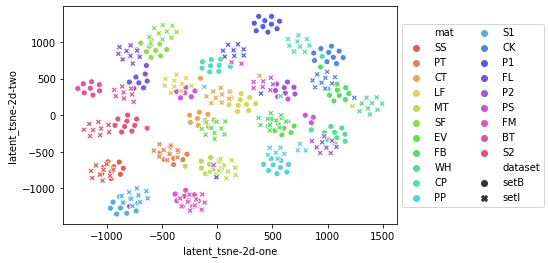

In [9]:
# visualize with sns
# extract columns from dataframe
df_B = df[["latentB_tsne-2d-one", "latentB_tsne-2d-two", "y", "mat"]]
df_I = df[["latentI_tsne-2d-one", "latentI_tsne-2d-two", "y", "mat"]]
subset_B = df_B.rename(columns={"latentB_tsne-2d-one": "latent_tsne-2d-one", "latentB_tsne-2d-two": "latent_tsne-2d-two", "y":"y", "mat":"mat"})
subset_I = df_I.rename(columns={"latentI_tsne-2d-one": "latent_tsne-2d-one", "latentI_tsne-2d-two": "latent_tsne-2d-two", "y":"y", "mat":"mat"})

concatenated = pd.concat([subset_B.assign(dataset='setB'), subset_I.assign(dataset='setI')])

img = sns.scatterplot(
x="latent_tsne-2d-one", y="latent_tsne-2d-two",
hue="mat",
style="dataset",
palette=sns.color_palette("hls", 20, desat=1),
data=concatenated,
legend="full",
alpha=0.99)

#set legend position
# img.set_position([0,0, 1, 0.8])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
# set title
# img.set(title = 'Perplexity: {}'.format(perplexity))
# plt.savefig("PT_tsne_BI_joint_sns_epoch_{}.png".format(str(epoch+1)), dpi=1200)
# save legend outside

plt.savefig("PT_tsne_BI_sns_epoch_{}.png".format(str(epoch+1)), dpi=1200, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

Computing pairwise distances...
Computing P-values for point 0 of 192...
Mean value of sigma: 2.449369
Computing pairwise distances...
Computing P-values for point 0 of 192...
Mean value of sigma: 2.425251
Computing pairwise distances...
Computing P-values for point 0 of 192...
Mean value of sigma: 0.573046
training started @lr=10,epoch=400,weight_decay=0,momentum=1
running epoch=0
running epoch=100
running epoch=200
running epoch=300
seed: 1, final loss = 48.5106086730957


/home/students/student9_02/project/transfer_learning/timeseries-clustering-vae/tsne/joint_tsne.py:456: RuntimeWarning: divide by zero encountered in log10
  ax5.plot(np.log10(loss4_his))


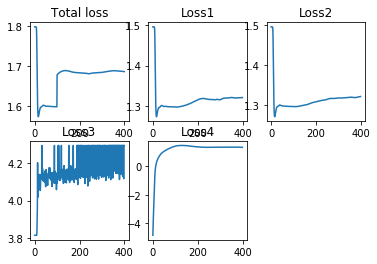

In [10]:
# initialize and train pytorch joint-TSNE
TJ = joint_tsne.myJointTSNE(XB, XI)
resB, resI = TJ.train(epoch=400, lr=10, weight_decay=0, momentum=1, show=True)
resB, resI = resB.numpy(), resI.numpy()

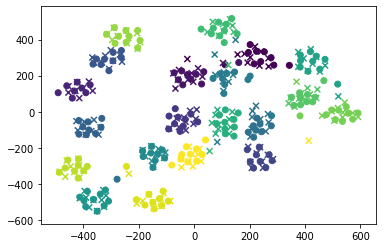

In [11]:
# visualize with matplotlib, legend not solved
fig, ax = plt.subplots()
ax.scatter(resB[:,0],resB[:,1],c=C.numpy(), marker='o')
ax.scatter(resI[:,0],resI[:,1],c=C.numpy(), marker='x')
plt.savefig("PT_tsne_BI_joint_epoch_{}.png".format(str(epoch+1)), dpi=1200)

In [12]:
# prepare dataframe for sns
import seaborn as sns
import pandas as pd

tsne_columns = ['latentB_tsne-2d-one', 'latentB_tsne-2d-two', 'latentI_tsne-2d-one', 'latentI_tsne-2d-two']
print("resB", resB.shape)
data = np.concatenate((resB, resI), axis=1)
print(data.shape)
df = pd.DataFrame(data, columns=tsne_columns)
print(df.shape)
df['y'] = C.numpy()
# df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
df['mat'] = df.apply(lambda row: mat_list[int(row.y)], axis=1)
print(df.shape)
print(df.head())

resB (192, 2)
(192, 4)
(192, 4)
(192, 6)
   latentB_tsne-2d-one  latentB_tsne-2d-two  latentI_tsne-2d-one  \
0          -419.228455          -367.240753          -415.214691   
1          -184.384811          -248.030731          -176.609573   
2           -45.149040           226.132095           -54.961914   
3           -90.760071           -24.025814           -36.558178   
4           -22.955643          -277.821930           -21.066597   

   latentI_tsne-2d-two     y mat  
0          -366.268799  17.0  SS  
1          -246.890244   9.0  PT  
2           231.733261   1.0  CT  
3           -31.974514   3.0  LF  
4          -274.439148  19.0  MT  


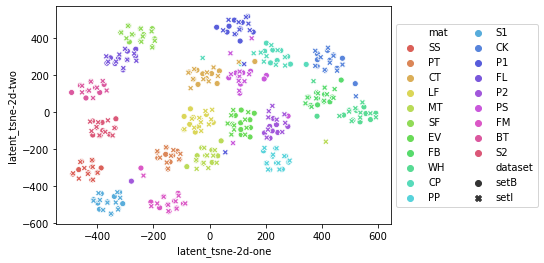

In [13]:
# visualize with sns
# extract columns from dataframe
df_B = df[["latentB_tsne-2d-one", "latentB_tsne-2d-two", "y", "mat"]]
df_I = df[["latentI_tsne-2d-one", "latentI_tsne-2d-two", "y", "mat"]]
subset_B = df_B.rename(columns={"latentB_tsne-2d-one": "latent_tsne-2d-one", "latentB_tsne-2d-two": "latent_tsne-2d-two", "y":"y", "mat":"mat"})
subset_I = df_I.rename(columns={"latentI_tsne-2d-one": "latent_tsne-2d-one", "latentI_tsne-2d-two": "latent_tsne-2d-two", "y":"y", "mat":"mat"})

concatenated = pd.concat([subset_B.assign(dataset='setB'), subset_I.assign(dataset='setI')])

img = sns.scatterplot(
x="latent_tsne-2d-one", y="latent_tsne-2d-two",
hue="mat",
style="dataset",
palette=sns.color_palette("hls", 20, desat=1),
data=concatenated,
legend="full",
alpha=0.99)

#set legend position
# img.set_position([0,0, 1, 0.8])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
# set title
# img.set(title = 'Perplexity: {}'.format(perplexity))
# plt.savefig("PT_tsne_BI_joint_sns_epoch_{}.png".format(str(epoch+1)), dpi=1200)
# save legend outside

plt.savefig("PT_tsne_BI_joint_sns_epoch_{}.png".format(str(epoch+1)), dpi=1200, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()